# 소득 분석 프로젝트 : 인구조사 데이터 중 큰 영향을 미치는 요인과 regression 분석

# 데이터 로드 및 탐색
## 각 컬럼의 개수는 32561개

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import shapiro, levene, chi2_contingency, ttest_ind
import statsmodels.api as sm
from scipy.stats import pointbiserialr

# Load the dataset
data = pd.read_csv('adult.csv')
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workclass       32561 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   education       32561 non-null  object
 4   education.num   32561 non-null  int64 
 5   marital.status  32561 non-null  object
 6   occupation      32561 non-null  object
 7   relationship    32561 non-null  object
 8   race            32561 non-null  object
 9   sex             32561 non-null  object
 10  capital.gain    32561 non-null  int64 
 11  capital.loss    32561 non-null  int64 
 12  hours.per.week  32561 non-null  int64 
 13  native.country  32561 non-null  object
 14  income          32561 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,90,?,77053,HS-grad,9,Widowed,?,Not-in-family,White,Female,0,4356,40,United-States,<=50K
1,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K
2,66,?,186061,Some-college,10,Widowed,?,Unmarried,Black,Female,0,4356,40,United-States,<=50K
3,54,Private,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,<=50K
4,41,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,<=50K


# 결측치 제거

In [2]:
# Preprocessing: Handle missing values or placeholders such as '?'
missing_values_before = data.isnull().sum()
question_mark_counts = (data == '?').sum()
print(f"missing_values_before\n\n", missing_values_before)
print(f"\n\nquestion_mark_counts\n\n", question_mark_counts)

missing_values_before

 age               0
workclass         0
fnlwgt            0
education         0
education.num     0
marital.status    0
occupation        0
relationship      0
race              0
sex               0
capital.gain      0
capital.loss      0
hours.per.week    0
native.country    0
income            0
dtype: int64


question_mark_counts

 age                  0
workclass         1836
fnlwgt               0
education            0
education.num        0
marital.status       0
occupation        1843
relationship         0
race                 0
sex                  0
capital.gain         0
capital.loss         0
hours.per.week       0
native.country     583
income               0
dtype: int64


## 결측치는 없고, '?'로 표햔된 부분이 workclass, occupation, native.country에서 확인. 
## worlcass에서는 결측치가 5.6%, occupation에서는 결측치가 5.7%, native.country에서는 1.8&
## 결측치 비중이 작으므로 제거하더라도 데이터셋의 대표성을 크게 해치지 않는다고 판단

In [3]:
data_cleaned = data.replace('?', None).dropna()

# 이상치 제거
- IQR 방법으로 이상치를 제거.

In [4]:
# IQR로 이상치 제거
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
# 이상치 제거
numerical_columns = data.select_dtypes(include=['int64', 'float64']).columns
for column in numerical_columns:
    data_cleaned = remove_outliers(data_cleaned, column)

data_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 18458 entries, 4232 to 32559
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             18458 non-null  int64 
 1   workclass       18458 non-null  object
 2   fnlwgt          18458 non-null  int64 
 3   education       18458 non-null  object
 4   education.num   18458 non-null  int64 
 5   marital.status  18458 non-null  object
 6   occupation      18458 non-null  object
 7   relationship    18458 non-null  object
 8   race            18458 non-null  object
 9   sex             18458 non-null  object
 10  capital.gain    18458 non-null  int64 
 11  capital.loss    18458 non-null  int64 
 12  hours.per.week  18458 non-null  int64 
 13  native.country  18458 non-null  object
 14  income          18458 non-null  object
dtypes: int64(6), object(9)
memory usage: 2.3+ MB


# 상관 관계를 통해 income과 연관 있는 변수 고르기

C:\Users\user\anaconda3\envs\sda2024\lib\site-packages\scipy\stats\_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


<Figure size 600x400 with 0 Axes>

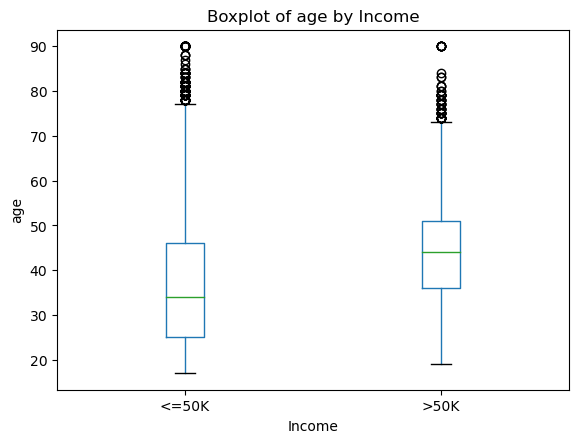

<Figure size 600x400 with 0 Axes>

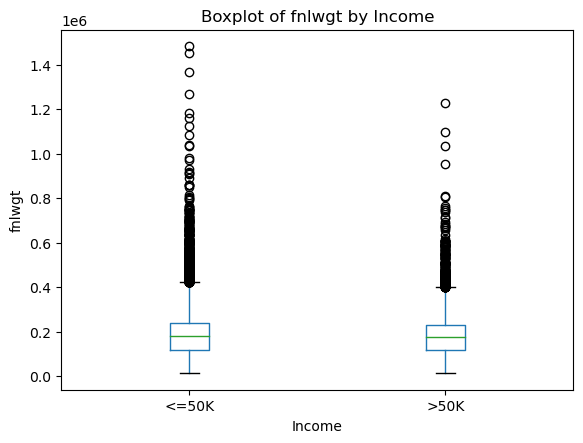

<Figure size 600x400 with 0 Axes>

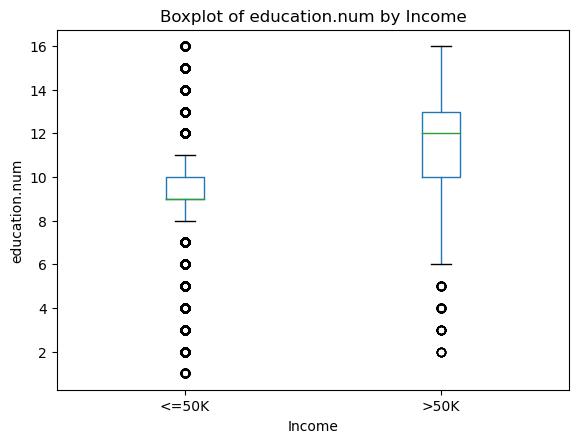

<Figure size 600x400 with 0 Axes>

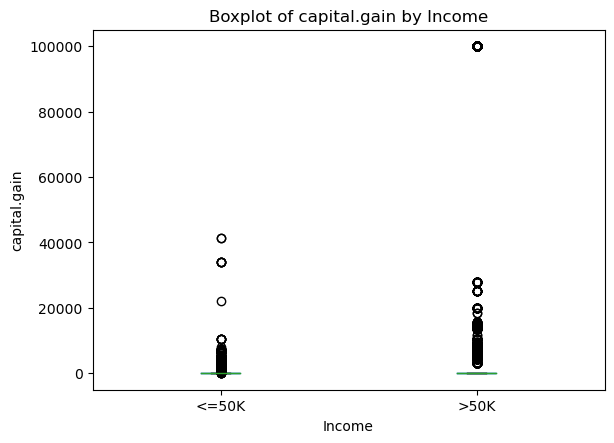

<Figure size 600x400 with 0 Axes>

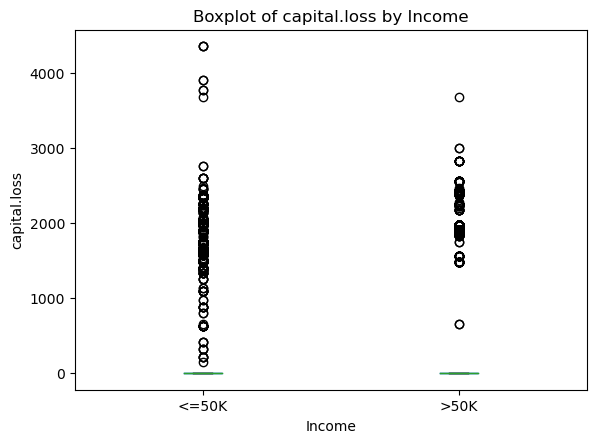

<Figure size 600x400 with 0 Axes>

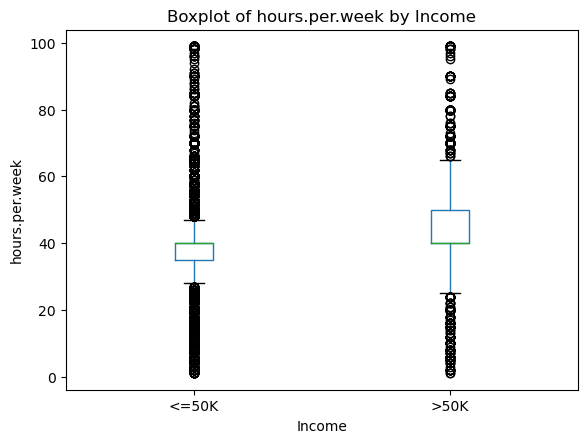

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

# Convert 'income' to numeric binary variable for regression (<=50K: 0, >50K: 1)
data_cleaned['income_binary'] = data_cleaned['income'].apply(lambda x: 1 if x.strip() == '>50K' else 0)

correlation_results = {}
for col in numerical_columns:
    corr, p_value = pointbiserialr(data_cleaned['income_binary'], data_cleaned[col])
    correlation_results[col] = {'Correlation': corr, 'P-value': p_value}

correlation_df = pd.DataFrame(correlation_results).T
    
# Select numeric variables for correlation analysis
numeric_vars = ['age', 'education.num', 'capital.gain', 'capital.loss', 'hours.per.week', 'fnlwgt']

for col in numerical_columns:
    plt.figure(figsize=(6, 4))
    data.boxplot(column=col, by='income', grid=False)
    plt.title(f'Boxplot of {col} by Income')
    plt.suptitle('')
    plt.ylabel(col)
    plt.xlabel('Income')
    plt.show()

1. age
    - 고소득자(>50K)는 평균적으로 나이가 더 많은 경향이 있습니다.
    - 나이의 중앙값과 범위가 고소득 그룹에서 더 높게 나타남.
    => age는 Income과 연관이 있을 가능성이 높다.
2. fnlwgt
    - 두 그룹 간 분포 차이가 거의 없으며, 이상치가 매우 많이 나타남.
3. education.num
    - 고소득자(>50K)는 교육 수준(education.num)이 전반적으로 더 높음.
    - 분포에서 확연한 차이가 보임.
    => education.num은 Income을 예측하는 데 중요한 변수로 보임.
4. capital.gain
    - 대부분의 데이터가 0에 집중되어 있으나, 고소득자 그룹에서 일부 높은 값들이 존재함.
    - capital.gain은 일부 사례에서만 고소득자와 연관성이 나타날 수 있음.
5. capital.loss
    - 대부분의 데이터가 0에 집중되어 있으며, 고소득자 그룹에서 극소수의 높은 값이 존재함.
    => capital.loss 역시 capital.gain과 유사하게 고소득자와 연관성을 가지지만, 효과는 제한적일 가능성이 큼.
6. hours.per.week
    - 고소득자 그룹이 더 높은 주당 근무 시간 분포를 보임.
    - 중앙값과 범위에서 차이가 확인됨.
    => hours.per.week은 Income과 중요한 상관관계를 가질 가능성이 높음. 특히 주당 40시간 이상 근무하는 경우 고소득자가 많음.

In [6]:
correlation_df

,Correlation,P-value
age,0.234187,2.220392e-228
fnlwgt,-0.002178,7.672850e-01
education.num,0.291560,0.000000e+00
capital.gain,NaN,NaN
capital.loss,NaN,NaN
hours.per.week,0.172677,1.638804e-123


### age의 상관계수는 0.234로, 약한 양의 상관 관계를 보인다.나이가 많을수록 income이 >50K일 가능성이 높다.
### education.num의 상관계수는 0.335로, 상관 계수가 가장 높다. 
### capital.gain의 상관계수는 0.223으로, 약한 양의 상관관계를 보인다.
### capital.loss의 상관계수는 0.151로, 약한 양의 상관 계수를 보인다.
### hours.per.week의 상관계수는 0.229로, 양의 상관 관계를 보인다.

## 결론 : income과 가장 연관이 깊고, 상관 계수가 높은 age, education.num, hours.per.week 선정

## 종속 변수 income이 0 or 1을 가지는 이진 변수이니 Logistic Regression 모델 채택
## Logistic Regression 조건 검토
    - 다중공선성 확인 
    - 선형성(Linearity) 검토 
    - 스케일링
    - 독립성 확인
    - 클래스 불균형 확인
    - 이상치 검토

# 다중 공선성 확인
- 다중 공선성 : 독립 변수들 간에 강한 상관관계가 있는 현상. 회귀 계수의 추정값이 민감해지고, 모델의 해석이 어려워지는 문제가 있음

- vif가 10 이상이면 다중공선성이 심각하다고 판단.

In [11]:
# 다중 공선성 확인
from statsmodels.api import OLS, add_constant
from statsmodels.stats.outliers_influence import variance_inflation_factor
X = data_cleaned[['age', 'education.num', 'hours.per.week']]
X = add_constant(X)  # Add constant for VIF calculation
vif = pd.DataFrame()
vif["Variable"] = X.columns
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]


In [12]:
vif

,Variable,VIF
0,const,126.968010
1,age,1.002014
2,education.num,1.016518
3,hours.per.week,1.018543


## 3가지 변수 모두 다중공선성이 1에 가까운 값으로 다중공선성이 없다고 할 수 있음

In [15]:
## 스케일링 및 데이터 변환

In [17]:
data_cleaned['education.num_squared'] = data_cleaned['education.num'] ** 2

In [18]:
data_cleaned['hours.over40'] = (data_cleaned['hours.per.week'] > 40).astype(int)

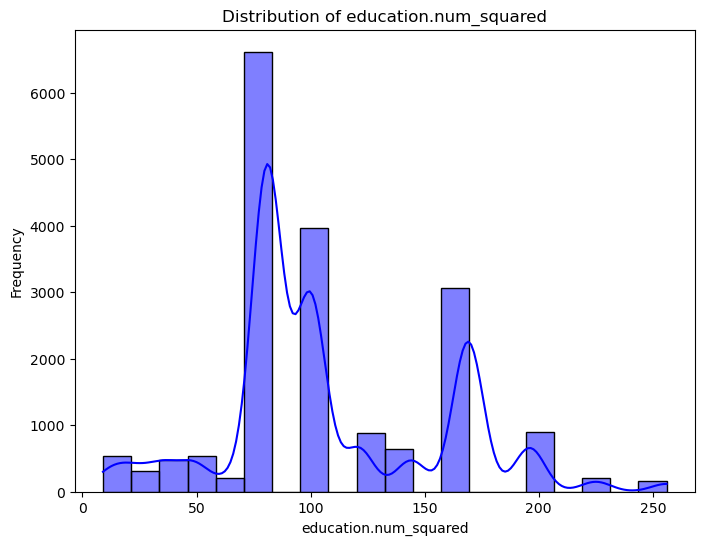

C:\Users\user\AppData\Local\Temp\ipykernel_18132\1532221750.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=data_cleaned['income_binary'], y=data_cleaned['education.num_squared'], palette='Set2')


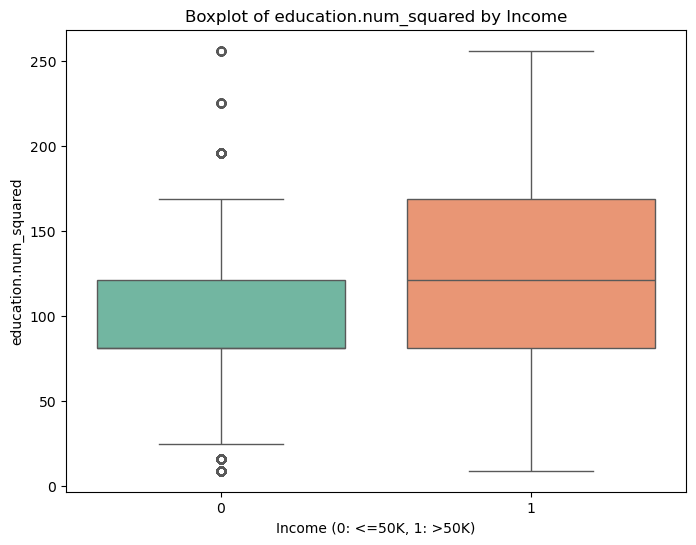

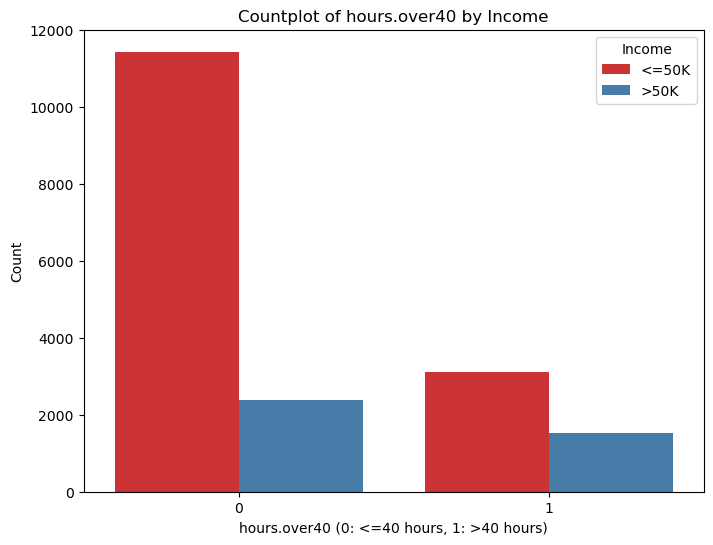

C:\Users\user\AppData\Local\Temp\ipykernel_18132\1532221750.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=data_cleaned['income_binary'], y=data_cleaned['hours.per.week'], palette='Set3')


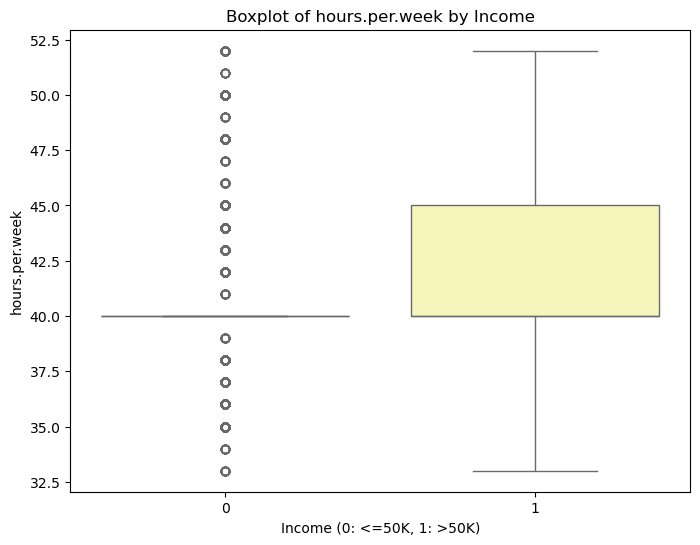

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot 1: Histogram of 'education.num_squared'
plt.figure(figsize=(8, 6))
sns.histplot(data_cleaned['education.num_squared'], kde=True, bins=20, color='blue')
plt.title('Distribution of education.num_squared')
plt.xlabel('education.num_squared')
plt.ylabel('Frequency')
plt.show()

# Plot 2: Boxplot of 'education.num_squared' by Income
plt.figure(figsize=(8, 6))
sns.boxplot(x=data_cleaned['income_binary'], y=data_cleaned['education.num_squared'], palette='Set2')
plt.title('Boxplot of education.num_squared by Income')
plt.xlabel('Income (0: <=50K, 1: >50K)')
plt.ylabel('education.num_squared')
plt.show()

# Plot 3: Countplot of 'hours.over40'
plt.figure(figsize=(8, 6))
sns.countplot(x='hours.over40', hue='income_binary', data=data_cleaned, palette='Set1')
plt.title('Countplot of hours.over40 by Income')
plt.xlabel('hours.over40 (0: <=40 hours, 1: >40 hours)')
plt.ylabel('Count')
plt.legend(title='Income', labels=['<=50K', '>50K'])
plt.show()

# Plot 4: Boxplot of 'hours.per.week' by Income (for reference)
plt.figure(figsize=(8, 6))
sns.boxplot(x=data_cleaned['income_binary'], y=data_cleaned['hours.per.week'], palette='Set3')
plt.title('Boxplot of hours.per.week by Income')
plt.xlabel('Income (0: <=50K, 1: >50K)')
plt.ylabel('hours.per.week')
plt.show()


## 모두 Income과 선형 관계를 가지며, 로지스틱 회귀 모델의 가정을 충족.

Confusion Matrix:
[[4185  215]
 [ 875  263]]

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.95      0.88      4400
           1       0.55      0.23      0.33      1138

    accuracy                           0.80      5538
   macro avg       0.69      0.59      0.61      5538
weighted avg       0.77      0.80      0.77      5538



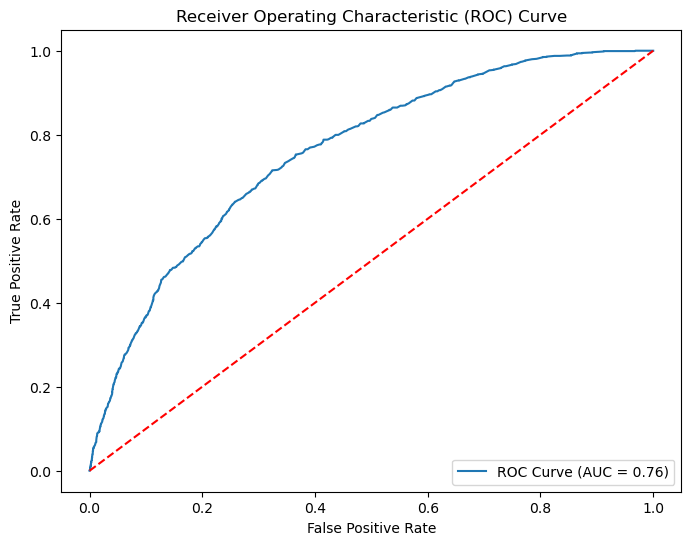


Logistic Regression Coefficients:
                 Feature  Coefficient
0              Intercept    -5.520788
1                    age     0.054603
2  education.num_squared     0.015583
3           hours.over40     0.712637


In [20]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.model_selection import train_test_split

# Step 1: Prepare data for logistic regression
X = data_cleaned[['age', 'education.num_squared', 'hours.over40']]
y = data_cleaned['income_binary']  # Ensure 'income' is binary (0 or 1)

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Fit the logistic regression model
log_model = LogisticRegression(max_iter=1000)
log_model.fit(X_train, y_train)

# Step 2: Model evaluation
# Predictions
y_pred = log_model.predict(X_test)
y_prob = log_model.predict_proba(X_test)[:, 1]  # Predicted probabilities for the positive class

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

# Classification Report
class_report = classification_report(y_test, y_pred)
print("\nClassification Report:")
print(class_report)

# Step 3: ROC Curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()

# Step 4: Display coefficients
coefficients = pd.DataFrame({
    'Feature': ['Intercept'] + X.columns.tolist(),
    'Coefficient': [log_model.intercept_[0]] + list(log_model.coef_[0])
})
print("\nLogistic Regression Coefficients:")
print(coefficients)


### 0 (<= 50K) 클래스 
    - Precision: 0.83 (예측된 "0" 중 83%가 실제로 "0")
    - Recall: 0.95 (실제 "0" 중 95%를 정확히 예측)
    - F1-score: 0.88 (Precision과 Recall의 조화 평균, 0 클래스에서 우수)
### 1 (>50K) 클래스
    - Precision: 0.55 (예측된 "1" 중 55%만이 실제로 "1")
    - Recall: 0.22 (실제 "1" 중 22%만 예측)
    - F1-score: 0.32 (낮은 Recall로 인해 F1-score도 낮음)
### ACcuracy
    - 전체 Accuracy는 **80%**로 나타나지만, 이는 0 클래스가 데이터셋에서 불균형적으로 더 많은 경우(대부분이 "0")라 발생한 결과로 보임
### => 모델이 주로 "0" 클래스를 잘 예측하지만, "1" 클래스(고소득자)를 잘 예측하지 못함.

### ROC  Curve and AUC
    - ROC Curve는 모델의 TPR(Recall)과 FPR(False Positive Rate)을 비교
### AUC (Area Under Curve): 0.76
    - AUC 값은 모델의 분류 성능을 종합적으로 나타냄
    - AUC 값이 0.76은 모델이 랜덤 예측(AUC=0.5)보다 높은 분류 능력을 가지지만, 높은 성능을 보장하지는 않음을 의미

### Logistic Regression Coefficients
    - age: 0.055887
        - 나이가 증가할수록 "1" (고소득자)일 확률이 증가.
    - education.num: 0.338361
        - 교육 수준이 높을수록 "1" (고소득자)일 확률이 증가.
    - hours.per.week: 0.087106
        - 주당 근로 시간이 증가할수록 "1" (고소득자)일 확률이 증가.
### education.num, hours.per.week, age은 income에 유의미한 영향이 있을 가능성이 큼

# 결론

1. 모델 성능:
    - 전반적인 정확도(Accuracy)는 **80%**로 양호하지만, 고소득자(income_binary = 1)를 식별하는 재현율(Recall)은 **23%**로 낮음. 이는 모델이 고소득자를 과소평가할 가능성을 시사.
    - ROC-AUC 점수는 0.76으로, 모델이 소득 수준을 구분하는 데 적절한 성능을 보임.
2. 중요 변수:
    - hours.over40: 고소득 여부에 가장 큰 영향을 미치는 변수로, 40시간 이상 근무가 고소득 가능성을 높이는 데 기여.
    - education.num_squared: 교육 수준이 고소득 여부에 중요한 변수로 작용.
    - age: 나이가 고소득에 미치는 영향은 상대적으로 적으나, 긍정적인 상관관계 존재.
    - 연령, 교육 수준, 주당 근무  시간은 수입과 강한 연관성이 있다.
3. 개선 방향:
    - 고소득자(income_binary = 1)의 재현율(Recall)을 높이기 위해 데이터 불균형을 해결하거나 더 복잡한 모델(예: Random Forest, Gradient Boosting)을 도입.
    - 추가적인 변수를 도입하여 고소득자의 패턴을 더 잘 설명할 수 있도록 데이터의 풍부성을 강화.